In [2]:
from inspect import ismethod
from IPython.display import HTML as html_print
from matplotlib import pyplot as plt
import numpy as np

from validphys.api import API
from validphys.commondataparser import parse_commondata_new
from validphys.loader import TheoryMetadataNotFound, Loader
l = Loader()
fig = None

LHAPDF 6.5.3 loading all 101 PDFs in set NNPDF40_nnlo_as_01180
NNPDF40_nnlo_as_01180, version 1; 101 PDF members


/Users/jumax9/Academic_Workspace/NNPDF/src/nnpdf/validphys2/src/validphys/utils.py:209: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for same_vals, table in gb:


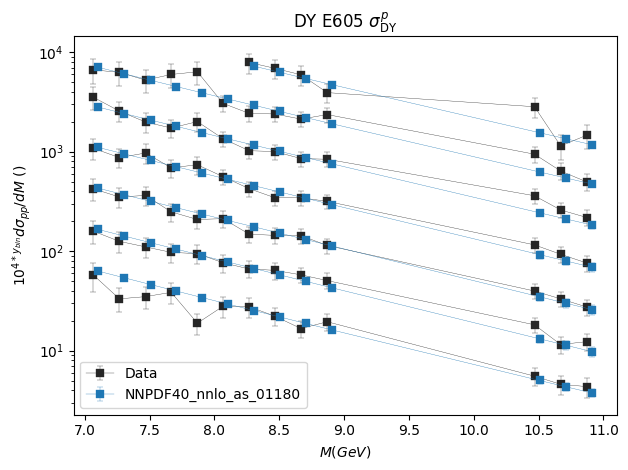

In [3]:
if True:
    cpred = API.plot_fancy(
        dataset_input={"dataset": "E605_DY_38P8GEV_PXSEC"},
        use_cuts="internal", 
        theoryid=400,
        pdf="NNPDF40_nnlo_as_01180",
        fit="230718-jcmwfaser-001"
    )
    fig = next(cpred)
    plt.show()
fig

/Users/jumax9/Academic_Workspace/NNPDF/src/nnpdf/validphys2/src/validphys/utils.py:209: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for same_vals, table in gb:


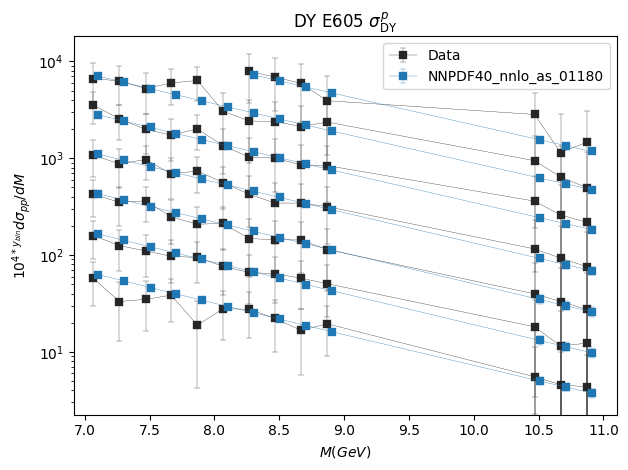

In [4]:
if True:
    cpred = API.plot_fancy(
        dataset_input={"dataset": "DYE605_dw_ite"},
        use_cuts="internal", 
        datacuts={"q2min": 3.49, "w2min": 12.5},
        theoryid=400,
        pdf="NNPDF40_nnlo_as_01180"
    )
    fig = next(cpred)
    plt.show()
fig

In [ ]:
if False:
    aa = API.dataset(
        dataset_input={"dataset": 'H1_1JET_319GEV_290PB-1_DIF_PTQ2'},
        use_cuts="internal",
        theoryid=400,
        pdf="NNPDF40_nnlo_as_01180").load_commondata()
    aa.central_values

In [4]:
API.central_predictions(
    dataset_input={"dataset": 'H1_1JET_319GEV_290PB-1_DIF_PTQ2'},
    use_cuts="internal",
    theoryid=400,
    pdf="NNPDF40_nnlo_as_01180")

LHAPDF 6.5.3 loading /opt/homebrew/Cellar/lhapdf/6.5.3/share/LHAPDF/NNPDF40_nnlo_as_01180/NNPDF40_nnlo_as_01180_0000.dat
NNPDF40_nnlo_as_01180 PDF set, member #0, version 1; LHAPDF ID = 331100


0
data             
0     1158.076387
1      390.349916
2       88.867318
3       15.699019
4        2.657003
5        0.466801
6     1165.829661
7      418.877986
8       96.751173
9       17.463828
10       2.994658
11       0.535526
12     840.683389
13     314.891903
14      76.428244
15      14.016267
16       2.425003
17       0.439531
18     687.805860
19     270.418050
20      69.530812
21      12.987857
22       2.251394
23       0.416488
24     594.147248
25     253.720781
26      68.207374
27      13.279612
28       2.347004
29       0.436889
30     481.831795
31     224.462957
32      65.477119
33      13.122646
34       2.374359
35       0.444835
36     303.689276
37     147.969914
38      46.772040
39       9.774865
40       1.835099
41       0.346541
42     303.689276
43     147.969914
44      46.772040
45       9.774865
46       1.835099
47       0.346541

## Old-New comparison

The next cells use `parse_commondata` and `pase_commondata_new` to compare the `CommonData` objects returned by parsing common data files in the old and new styles.

At the moment the "new commondatas" are in a hard-coded folder called `new_data` (it is hardcoded in `commondataparser.py` while the old ones are taken from whatever was installed in `share/NNPDF/data`. Eventually the new commondata will also live there.

The comparison checks that the data, uncertainties and kinematics are the same (or as close as they can be). The format of the dataframes is slightly different at the moment, but this is at the moment a desired result.

In [3]:
# Helper functions
def load_new(new_name, theoryid=400):
    try:
        new_cd = API.dataset(dataset_input={"dataset": new_name}, use_cuts="nocuts", theoryid=theoryid).load_commondata()
    except Exception as e:
         # NNPDF datasets by definition also have a theory available, datasets without a theory will fail with AttributeError
        if not isinstance(e.args[0],TheoryMetadataNotFound):
            raise e
        new_cd = l.check_commondata(new_name).load()
    return new_cd

def load_old_and_new(old_name, new_name, theoryid=400):
    """Load the old and new commondata. The theory id is needed by the validphys API when using .dataset
    but it is never used. 
    Putting 400 as default since I guess everyone has that theory installed already and the new format
    works only with the pineappl theories
    """
    
    # If this doesn't find your data, change the path inside `loader.py` to wherever your data is
    # the variable is `_folder_data` is inside the `check_commondata` function

    # Currently validphys understand a dataset is in the "new" format if no .dat file is found
    old_cd = API.dataset(dataset_input={"dataset": old_name}, use_cuts="nocuts", theoryid=theoryid).load_commondata()
    new_cd = load_new(new_name, theoryid=theoryid)
        
    if new_cd.legacy:
        print("Oh no!")
        raise FileNotFoundError("The new cd was loaded as an old one, something bad happened")
    if not old_cd.legacy:
        print("Oh no!")
        raise FileNotFoundError("The old cd was loaded as a new one, something bad happened")

    return old_cd, new_cd

def print_check(msg, res):
    color = "green" if res else "red"
    display(html_print(f"<text style=color:{color}>equal={res} {msg}</text>"))

def check_this(cds, method, naming=None, unc=False):
    """Check whether the results of `method` for two different commondata agree"""
    if len(cds) != 2:
        raise ValueError(f"Can only check two commondata, not {len(cds)}")
        
    test = None
    check_result = True
    if naming is None:
        naming = method
    
    values = []
    for cd in cds:
        res = getattr(cd, method)
        if ismethod(res): # since sometimes we have methods, sometimes they are attributes
            res = res()
        values.append(res)
        
    check_result = np.allclose(*values)
    
    print_check(f"Testing {naming} ({method})", check_result)
    
    if not check_result:
        nnn = (values[0]+values[1]) + 1e-7
        val = np.max( (values[0]-values[1])/nnn*100)
        if val == val:
            print(f"       Max % diff: {np.abs(val)}")

def check_systematics(cds):
    additive_attr = "additive_errors"
    multipli_attr = "multiplicative_errors"
    
    add = []
    mult = []
    covmats = []
    syserr = []
    
    nsys = cds[0].nsys

    for cd in cds:
        if cd.nsys != nsys:
            print_check(f"The number of systematic uncertainites is different!!", False)
            # it doesn't make sense to continue here
            return
            
        res_add = getattr(cd, additive_attr)
        res_mult = getattr(cd, multipli_attr)
        res_sys = cd.systematic_errors()
        
        add.append(res_add)
        mult.append(res_mult)
        syserr.append(res_sys)
        covmats.append(res_add @ res_add.T)
    
    # Even if the number of systematics is the same, it is not a given that they are
    # distributed in the same way between multiplicative and additive, check that
    all_nmul = [i.shape[-1] for i in mult]    
    if not len(np.unique(all_nmul)) == 1:
        print(f" > The combination of multiplicative and additive is different!")
        check_sys = np.allclose(*syserr)
        print_check(f"Testing the raw table of systematics: systematic_errors()", check_sys)
        return

    check_multiplicative = np.allclose(*mult)
    print_check(f"Testing multiplicative errors ({multipli_attr})", check_multiplicative)
        
    check_additive = np.allclose(*add)
    print_check(f"Testing additive errors ({additive_attr})", check_additive)
    
    # When checking additive uncertainties, check also the covmat obtained from res @ res.T
    # since there might -1 signs in the eigenvectors
    if not check_additive:
        check_again = np.allclose(*covmats)
        print(" > > The resulting covmat instead agrees? ", check_again)
        

def run_checks(old_cd, new_cd):
    """Run through a number of checks to ensure they contain the same information"""
    cds = [old_cd, new_cd]
        
    check_this(cds, "get_cv", naming="central_values")
    check_this(cds, "get_kintable", naming="kinematics")
    check_this(cds, "stat_errors")
    check_systematics(cds)
    
    
def parsedat(dat_str):
    """Parse info from https://github.com/NNPDF/nnpdf/issues/1709"""
    ret = "datasets = {"
    for i in dat_str.split("\n"):
        sp = i.strip().split("|")
        new = f'"{sp[1].strip()}"'
        old = sp[2].strip()
        if old == "NA":
            old = "None"
        else:
            old = f'"{old}"'
        ret += f"\n    {new} : {old},"
    ret += "\n}"
    print(ret)

In [5]:
def test_group(datasets, nofail=False, only_reader=False, skip = None):
    all_cds = []
    for i, (new_name, old_name) in enumerate(datasets.items()):
        if skip is not None:
            if i < skip:
                continue
        print(f"\nChecking {i} {new_name} (old name: {old_name})")
        try:
            old_cd, new_cd = load_old_and_new(old_name, new_name)
            all_cds.append((old_cd, new_cd))
            
            if old_cd is not None and not only_reader:
                print(" > Comparing values...")
                run_checks(old_cd, new_cd)
            else:
                print(" > New commondata read ok")
                
        except FileNotFoundError:
            print(f"Files for {new_name} not found")
            continue
        except Exception as e:
            if nofail:
                print(f"### FAILED for {new_name}\n")
                continue
            raise e
    return all_cds

## FT Drell-yan

These datasets can be found in the `E605` branch [#1679](https://github.com/NNPDF/nnpdf/pull/1679)

In [6]:
datasets = {
    "E605_DY_38P8GEV_PXSEC":"DYE605_dw_ite",
    "E866_DY_800GEV_PXSEC":"DYE886P",
    "E866_DY_800GEV_RATIO_PDXSECRATIO":"DYE886R_dw_ite",
    "E906_DY_120GEV_PDXSECRATIO":"DYE906R_dw_ite",
}

res_ft = test_group(datasets, nofail=False)


#old_cd, new_cd = load_old_and_new("DYE906R_dw_ite", "E906_DY_120GEV_PDXSECRATIO")
#run_checks(old_cd, new_cd)


Checking 0 E605_DY_38P8GEV_PXSEC (old name: DYE605_dw_ite)
 > Comparing values...


       Max % diff: 2.1972405622258293



Checking 1 E866_DY_800GEV_PXSEC (old name: DYE886P)
 > Comparing values...


       Max % diff: 0.980564514698334


       Max % diff: 59.707706745413326


       Max % diff: 0.9805644629707937


 > > The resulting covmat instead agrees?  False

Checking 2 E866_DY_800GEV_RATIO_PDXSECRATIO (old name: DYE886R_dw_ite)
 > Comparing values...


       Max % diff: 1.4597762371233123



Checking 3 E906_DY_120GEV_PDXSECRATIO (old name: DYE906R_dw_ite)
 > Comparing values...


## Atlas datasets

These datasets can be found in the `gluon_pdf_ncd` branch

In [5]:
datasets = {
    "ATLAS_1JET_13TEV_DIF_PT-Y" : None,
    "ATLAS_1JET_13TEV_DIF_PT-Y_ALTCORR1" : None,
    "ATLAS_2JET_13TEV_DIF_MJJ-Y" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_MTTBAR" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_MTTBAR-NORM" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_PTT" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_PTT-NORM" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_YT" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_YT-NORM" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_YTTBAR" : None,
    "ATLAS_TTBAR_13TEV_LJ_DIF_YTTBAR-NORM" : None,
    "ATLAS_TTBAR_13TEV_TOT_X-SEC" : "ATLASTTBARTOT13TEV",
    "ATLAS_TTBAR_7TEV_TOT_X-SEC" : "ATLASTTBARTOT7TEV",
    "ATLAS_TTBAR_8TEV_2L_DIF_MTTBAR" : "ATLAS_TOPDIFF_DILEPT_8TEV_TTM",
    "ATLAS_TTBAR_8TEV_2L_DIF_MTTBAR-NORM" : "ATLAS_TOPDIFF_DILEPT_8TEV_TTMNORM",
    "ATLAS_TTBAR_8TEV_2L_DIF_YTTBAR" : "ATLAS_TOPDIFF_DILEPT_8TEV_TTRAP",
    "ATLAS_TTBAR_8TEV_2L_DIF_YTTBAR-NORM" : "ATLAS_TOPDIFF_DILEPT_8TEV_TTRAPNORM",
    "ATLAS_TTBAR_8TEV_LJ_DIF_MTTBAR" : "ATLAS_TTB_DIFF_8TEV_LJ_TTM",
    "ATLAS_TTBAR_8TEV_LJ_DIF_MTTBAR-NORM" : "ATLAS_TTB_DIFF_8TEV_LJ_TTMNORM",
    "ATLAS_TTBAR_8TEV_LJ_DIF_PTT" : "ATLAS_TTB_DIFF_8TEV_LJ_TPT",
    "ATLAS_TTBAR_8TEV_LJ_DIF_PTT-NORM" : "ATLAS_TTB_DIFF_8TEV_LJ_TPTNORM",
    "ATLAS_TTBAR_8TEV_LJ_DIF_YT" : "ATLAS_TTB_DIFF_8TEV_LJ_TRAP",
    "ATLAS_TTBAR_8TEV_LJ_DIF_YT-NORM" : "ATLAS_TTB_DIFF_8TEV_LJ_TRAPNORM",
    "ATLAS_TTBAR_8TEV_LJ_DIF_YTTBAR" : "ATLAS_TTB_DIFF_8TEV_LJ_TTRAP",
    "ATLAS_TTBAR_8TEV_LJ_DIF_YTTBAR-NORM" : "ATLAS_TTB_DIFF_8TEV_LJ_TTRAPNORM",
    "ATLAS_TTBAR_8TEV_TOT_X-SEC" : "ATLASTTBARTOT8TEV",
}
 
#res = test_group(datasets, nofail=True, only_reader=True, skip=None)


if False:
    new_name = list(datasets)[10]
    old_name = datasets[new_name]
    print(f"old: {old_name}, new: {new_name}")

    old_cd, new_cd = load_old_and_new(old_name, new_name)
    run_checks(old_cd, new_cd)

## CMS datasets

These datasets can be found in the `gluon_pdf_ncd` branch

In [6]:
datasets = {
    "CMS_1JET_13TEV_DIF_R04" : None,
    "CMS_1JET_13TEV_DIF_R07" : None,
    "CMS_TTBAR_13TEV_2L_DIF_MTTBAR" : "CMS_TTB_DIFF_13TEV_2016_2L_TTM",
    "CMS_TTBAR_13TEV_2L_DIF_MTTBAR-NORM" : "CMS_TTB_DIFF_13TEV_2016_2L_TTMNORM",
    "CMS_TTBAR_13TEV_2L_DIF_PTT" : "CMS_TTB_DIFF_13TEV_2016_2L_TPT",
    "CMS_TTBAR_13TEV_2L_DIF_PTT-NORM" : "CMS_TTB_DIFF_13TEV_2016_2L_TPTNORM",
    "CMS_TTBAR_13TEV_2L_DIF_YT" : "CMS_TTB_DIFF_13TEV_2016_2L_TRAP",
    "CMS_TTBAR_13TEV_2L_DIF_YT-NORM" : "CMS_TTB_DIFF_13TEV_2016_2L_TRAPNORM",
    "CMS_TTBAR_13TEV_2L_DIF_YTTBAR" : "CMS_TTB_DIFF_13TEV_2016_2L_TTRAP",
    "CMS_TTBAR_13TEV_2L_DIF_YTTBAR-NORM" : "CMS_TTB_DIFF_13TEV_2016_2L_TTRAPNORM",
    "CMS_TTBAR_13TEV_LJ_DIF_MTTBAR" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_MTTBAR-NORM" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_YTTBAR" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_YTTBAR-NORM" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_PTT" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_PTT-NORM" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_YT" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_YT-NORM" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_MTTBAR-YTTBAR" : None,
    "CMS_TTBAR_13TEV_LJ_DIF_MTTBAR-YTTBAR-NORM" : None,
    "CMS_TTBAR_13TEV_TOT_X-SEC" : "CMSTTBARTOT13TEV",
    "CMS_TTBAR_5TEV_TOT_X-SEC" : "CMSTTBARTOT5TEV",
    "CMS_TTBAR_7TEV_TOT_X-SEC" : "CMSTTBARTOT7TEV",
    "CMS_TTBAR_8TEV_2L_DIF_PTT-YT-NORM" : "CMS_TTBAR_2D_DIFF_PT_TRAP_NORM",
    "CMS_TTBAR_8TEV_2L_DIF_MTTBAR-YT-NORM" : "CMS_TTBAR_2D_DIFF_MTT_TRAP_NORM",
    "CMS_TTBAR_8TEV_2L_DIF_MTTBAR-YTTBAR-NORM" : "CMS_TTBAR_2D_DIFF_MTT_TTRAP_NORM",
    "CMS_TTBAR_8TEV_LJ_DIF_MTTBAR-NORM" : "CMSTOPDIFF8TEVTTMNORM",
    "CMS_TTBAR_8TEV_LJ_DIF_PTT-NORM" : "CMSTOPDIFF8TEVTPTNORM",
    "CMS_TTBAR_8TEV_LJ_DIF_YT-NORM" : "CMSTOPDIFF8TEVTRAPNORM",
    "CMS_TTBAR_8TEV_LJ_DIF_YTTBAR-NORM" : "CMSTOPDIFF8TEVTTRAPNORM",
    "CMS_TTBAR_8TEV_TOT_X-SEC" : "CMSTTBARTOT8TEV",
}

res = test_group(datasets, nofail=False, only_reader=False, skip=18)


Checking 18 CMS_TTBAR_13TEV_LJ_DIF_MTTBAR-YTTBAR (old name: None)
 > New commondata read ok

Checking 19 CMS_TTBAR_13TEV_LJ_DIF_MTTBAR-YTTBAR-NORM (old name: None)
 > New commondata read ok

Checking 20 CMS_TTBAR_13TEV_TOT_X-SEC (old name: CMSTTBARTOT13TEV)
 > Comparing values...


       Max % diff: 2.9908972689862874


       Max % diff: 0.3120838497055149


       Max % diff: 75.75757564279156



Checking 21 CMS_TTBAR_5TEV_TOT_X-SEC (old name: CMSTTBARTOT5TEV)
 > Comparing values...


       Max % diff: 0.0



Checking 22 CMS_TTBAR_7TEV_TOT_X-SEC (old name: CMSTTBARTOT7TEV)
 > Comparing values...


       Max % diff: 0.3120838497055149



Checking 23 CMS_TTBAR_8TEV_2L_DIF_PTT-YT-NORM (old name: CMS_TTBAR_2D_DIFF_PT_TRAP_NORM)
 > Comparing values...


       Max % diff: 0.9814028622220792


       Max % diff: 99.99980622850609



Checking 24 CMS_TTBAR_8TEV_2L_DIF_MTTBAR-YT-NORM (old name: CMS_TTBAR_2D_DIFF_MTT_TRAP_NORM)
 > Comparing values...


       Max % diff: 1.4970067401729883


       Max % diff: 99.9999697133545



Checking 25 CMS_TTBAR_8TEV_2L_DIF_MTTBAR-YTTBAR-NORM (old name: CMS_TTBAR_2D_DIFF_MTT_TTRAP_NORM)
 > Comparing values...


       Max % diff: 0.8061789013783482


       Max % diff: 99.9999697133545



Checking 26 CMS_TTBAR_8TEV_LJ_DIF_MTTBAR-NORM (old name: CMSTOPDIFF8TEVTTMNORM)
 > Comparing values...


       Max % diff: 0.3120838497055149


 > The combination of multiplicative and additive is different!



Checking 27 CMS_TTBAR_8TEV_LJ_DIF_PTT-NORM (old name: CMSTOPDIFF8TEVTPTNORM)


ConfigError: Could not find Commondata set: 'CMSTOPDIFF8TEVTPTNORM'. File '/Users/jumax9/Academic_Workspace/NNPDF/nnvortex/share/NNPDF/data/commondata/DATA_CMSTOPDIFF8TEVTPTNORM.dat' does not exist.
Instead of 'CMSTOPDIFF8TEVTPTNORM', did you mean one of the following?
 - CMSTOPDIFF8TEVTTMNORM
 - CMSTOPDIFF8TEVTRAPNORM
 - CMSTOPDIFF8TEVTTRAPNORM

# DIS data

In [ ]:
datasets = {
    "H1_1JET_319GEV_290PB-1_DIF_Q2PT" : None,
    "H1_1JET_319GEV_290PB-1_DIF_Q2PT-NORM" : None,
    "H1_1JET_319GEV_290PB-1_DIF_HIGH-Q2PT" : None,
    "H1_1JET_319GEV_290PB-1_DIF_HIGH-Q2PT-NORM" : None,
    "H1_1JET_319GEV_351PB-1_DIF_Q2PT" : None,
    "H1_1JET_319GEV_351PB-1_DIF_Q2PT-NORM" : None,
    "H1_2JET_319GEV_290PB-1_DIF_Q2PT" : None,
    "H1_2JET_319GEV_290PB-1_DIF_Q2PT-NORM" : None,
    "H1_2JET_319GEV_351PB-1_DIF_Q2PT" : None,
    "H1_2JET_319GEV_351PB-1_DIF_Q2PT-NORM" : None,
    "ZEUS_1JET_300GEV_38P6PB-1_DIF_Q2ET" : None,
    "ZEUS_1JET_319GEV_82PB-1_DIF_Q2ET" : None,
    "ZEUS_2JET_319GEV_374PB-1_DIF_Q2ET" : None,
}

res = test_group(datasets, nofail=True, only_reader=False, skip=None)

## CMS ttbar

These datasets can be found in the `more_efficient_metadata_for_new_commondata` branch [#1684](https://github.com/NNPDF/nnpdf/pull/1684)

In [ ]:
datasets = {
    "CMSTOPDIFF8TEVTTRAPNORM":  "CMS_TTBAR_8TEV_LJ_DIF_YTTBAR-NORM",
}

#res = test_group(datasets, nofail=False)